## Kaggle dataset -- Classifying the transaction as fraudulent or non-fraudulent

## Description
### Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

Content
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Past Research
There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932).

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

In [28]:
import imblearn

In [29]:
'''importing the required libraries'''

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
#plt.style.use('bmh')

'''Importing the dataset and checking its properties '''
df =  pd.read_csv("PS_20174392719_1491204439457_log.csv")

print(len(df))

6362620


In [30]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Check Data

In [31]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Checking for any null values


In [32]:
print('Null Values =',df.isnull().values.any())

Null Values = False


### Remove unwanted features


In [33]:
df.drop('nameOrig', axis=1, inplace=True)
df.drop('nameDest', axis=1, inplace=True)
df.drop('isFlaggedFraud', axis=1, inplace=True)

### Visualise the variables by grouping them by into classes

isFraud
0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

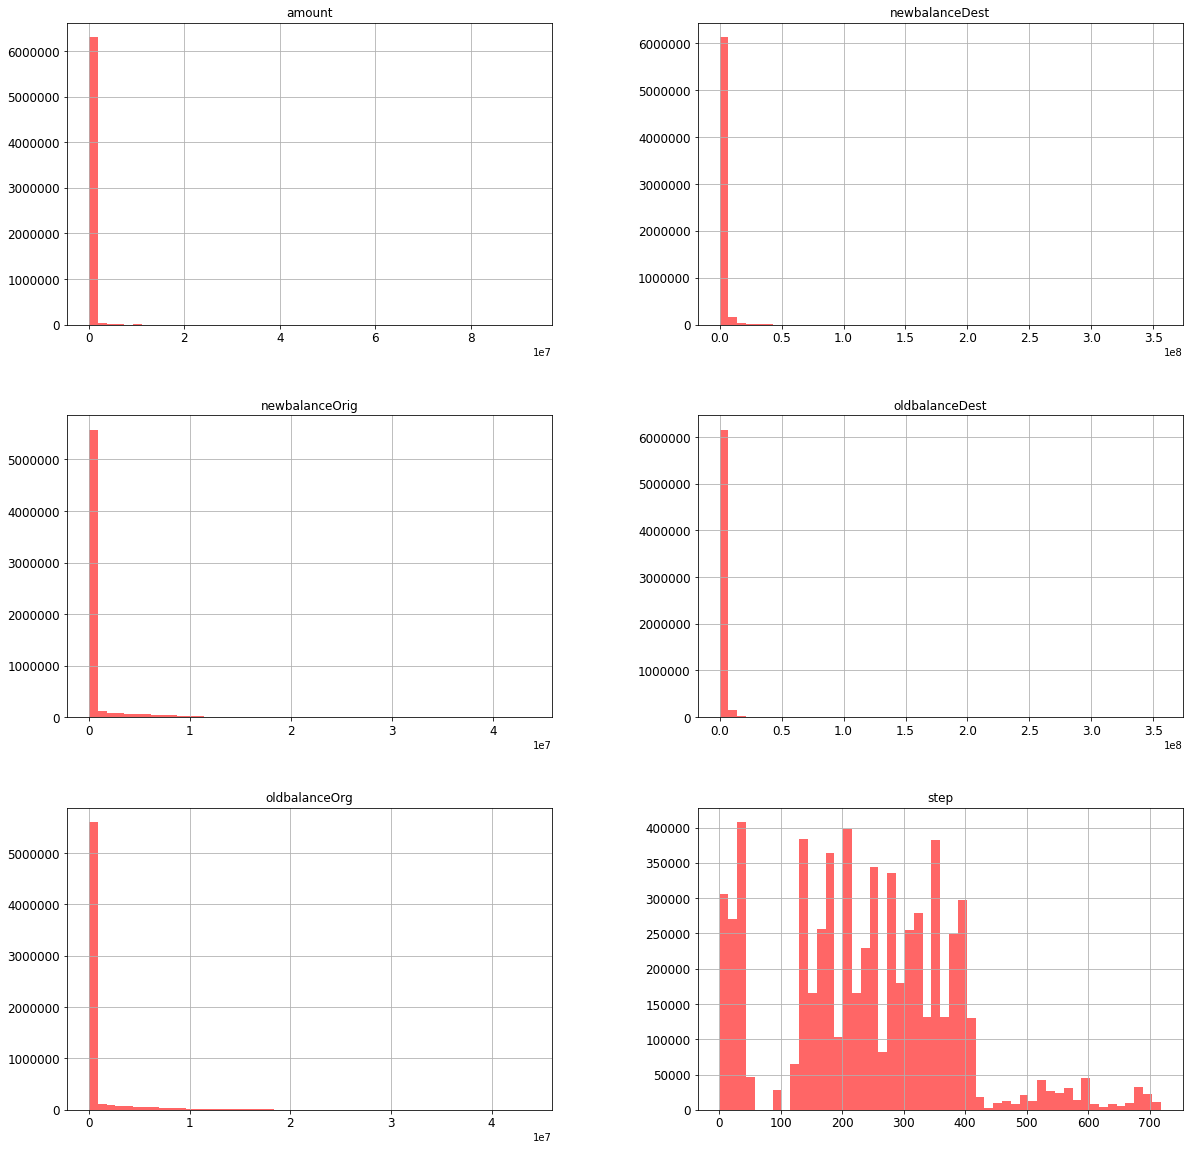

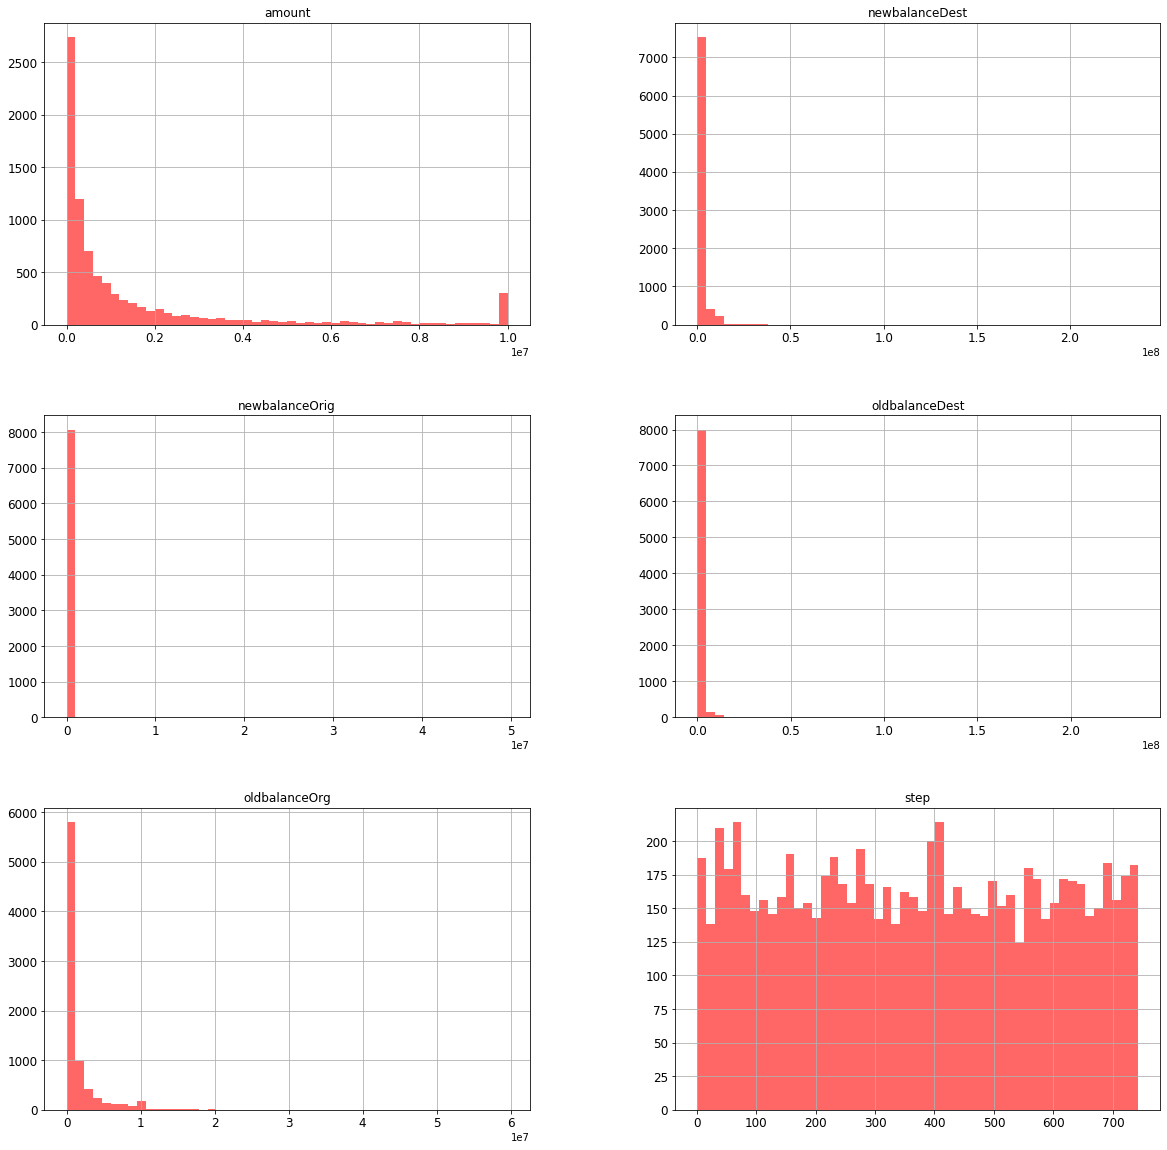

In [34]:

df.groupby('isFraud').hist(figsize=(20, 20), bins=50, xlabelsize=12, ylabelsize=12,alpha=0.6,color = "red",)

### Plot correlation matrix to check multicolinearity between variables


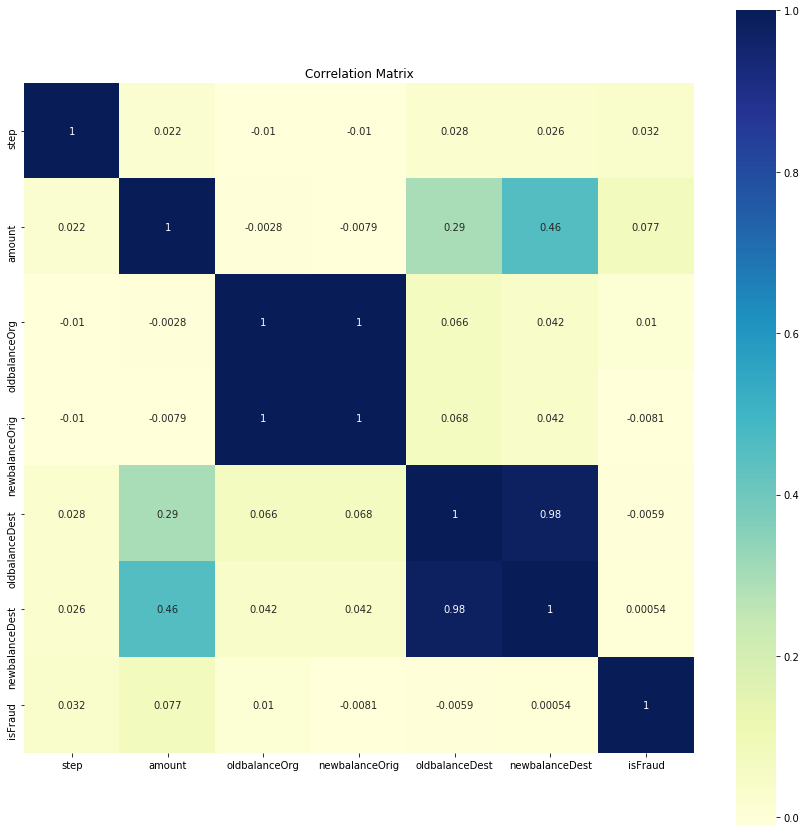

In [35]:

correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap="YlGnBu")

### Create dummy variables for categorical values


In [36]:
dum = pd.get_dummies(df['type'])
df1 = pd.concat([df,dum],axis=1)
df1.drop(['type'],axis=1, inplace=True)


### check if target class is balanced or not'''


0    19967
1       33
Name: isFraud, dtype: int64


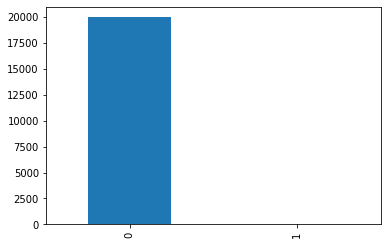

In [37]:

df2 = df1.sample(n=20000)
df2.isFraud.value_counts().plot.bar()
print(df2.isFraud.value_counts())

### Split data into training and test set

In [38]:

X_train, X_test, y_train, y_test = train_test_split(df2.drop(['isFraud'],axis=1), df2['isFraud'], test_size=0.3, random_state=0)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))


Before OverSampling, counts of label '1': 26
Before OverSampling, counts of label '0': 13974 



### Resample training data using SMOTE

In [39]:
# sm = SMOTE(random_state=10, ratio = 1.0)
sm = SMOTE(random_state=10)

x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (27948, 11)
After OverSampling, the shape of train_y: (27948,) 

After OverSampling, counts of label '1': 13974
After OverSampling, counts of label '0': 13974


### Rescale the features- Feature scaling

In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train_res)
x_test_scaled = sc.transform(X_test)


### Initialize and build fully connected network with sigmoid output to classify fraudulent transaction or not

In [41]:
model = Sequential()
model.add(Dense(input_dim=11, output_dim = 7, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 7, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

### Compile and fit the model -- on Training data

In [42]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_info = model.fit(x_train_scaled, y_train_res, batch_size = 10, nb_epoch = 15)

Epoch 1/15
27948/27948 [==============================] - 16s 563us/step - loss: 0.1957 - accuracy: 0.9238
Epoch 2/15
27948/27948 [==============================] - 15s 537us/step - loss: 0.0868 - accuracy: 0.9680
Epoch 3/15
27948/27948 [==============================] - 15s 535us/step - loss: 0.0703 - accuracy: 0.9759
Epoch 4/15
27948/27948 [==============================] - 15s 548us/step - loss: 0.0596 - accuracy: 0.9793
Epoch 5/15
27948/27948 [==============================] - 16s 567us/step - loss: 0.0523 - accuracy: 0.9813
Epoch 6/15
27948/27948 [==============================] - 17s 611us/step - loss: 0.0476 - accuracy: 0.9826
Epoch 7/15
27948/27948 [==============================] - 16s 556us/step - loss: 0.0440 - accuracy: 0.9835
Epoch 8/15
27948/27948 [==============================] - 15s 544us/step - loss: 0.0410 - accuracy: 0.9844
Epoch 9/15
27948/27948 [==============================] - 15s 538us/step - loss: 0.0388 - accuracy: 0.9848
Epoch 10/15
27948/27948 [============

### Plot training accuracy and losses over different epochs


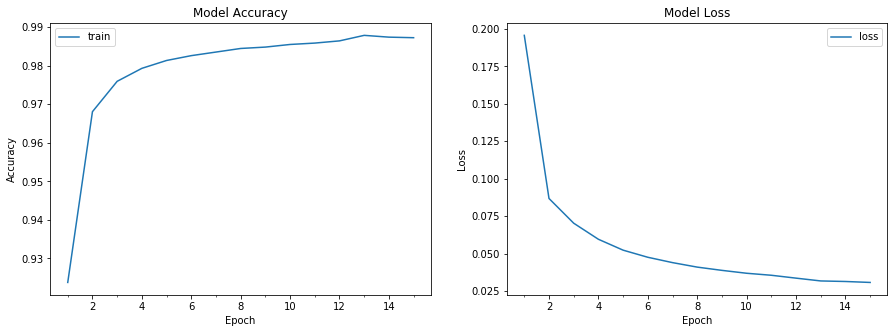

In [43]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    ### History for accuracy
    
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train'], loc='best')
    
    ### History for loss
    
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['loss'], loc='best')
    plt.show()
    
plot_model_history(model_info)

### Predict unseen data i.e. test data using the trained model


In [44]:
y_pred = model.predict_classes(x_test_scaled)
acc = accuracy_score(y_test,y_pred)*100
print('Accuracy:',round(acc,2))
print('Confusion matrix', '\n', confusion_matrix(y_test, y_pred), '\n')
print('Classification report', '\n', classification_report(y_test, y_pred), '\n')

Accuracy: 98.8
Confusion matrix 
 [[5921   72]
 [   0    7]] 

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      5993
           1       0.09      1.00      0.16         7

    accuracy                           0.99      6000
   macro avg       0.54      0.99      0.58      6000
weighted avg       1.00      0.99      0.99      6000
 



### Observation

#### As you can see, using simple fully connected neural network we were able to classify with very high accuracy (98.8%) whether the transaction is fraudulent or non-fraudulent. 